# 20240305-06 prepare sequences for DNN prediction
1. take deseq2 non-diff tables
2. make bedfiles from those tables, 
3. correlations between deseq2 concentrations in US, CTRL
4. compute peak midpoint and trim peaks to desired peaklen
5. make fasta from trimmed peaks
6. merge coordinates, target value concentrations, sequences

In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pbt

from scipy import stats

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# functions

In [12]:
def addCoor(df):
    """add genome coordinate col"""

    df["coor"] = df[df.columns[0]] + ":" + \
        df[df.columns[1]].map(str) + "-" + df[df.columns[2]].map(str)

    return df


def makeBed(df, filename, cl, dif_nodif):
    """ make a bed file from deseq2 diffbind files"""
    # file to write to
    out_bed = ".".join(filename.split(".")[:-1]) + ".bed"

    cols = list(df.columns[:3])


    if "type" in list(df):

        cols.append(df.columns[-1])
        save_cols = ['#chr', 'start', 'end', 'type']
        
        print(cols)
    else:
         save_cols = ['#chr', 'start', 'end']
        
    beddf = df[cols].drop_duplicates().copy().reset_index(drop=True)

    # rename the columns
    beddf.columns = save_cols

    # clean for any negative start sites. 
    beddf = beddf.loc[beddf["start"] > 0]
    
    # sort
    beddf = beddf.sort_values(by=["#chr", "start", "end"]).reset_index()
    

    # write file
    beddf[save_cols].to_csv(
        out_bed, sep='\t', index=False)

    # print("made", out_bed)

    return out_bed, beddf


def overlapDiffNondiff(out_beddif, out_bednondif, dif):
    """perform bedtools subtraction between two sets of coordinates, 
    count how many are not present in both. """

    cmd = " ".join(["bedtools intersect",
                    "-a",
                    out_beddif,
                    "-b",
                    out_bednondif,
                    "-wa -v",
                    "| wc -l"

                    ])
    print("n bedtools subtract")
    os.system(cmd)
    
    print("of", dif.shape[0], "\n\n")

    # write overlap of non-diff elements in differentially accessible peaks
    
    out_bed = ".".join(out_bednondif.split(".")[:-1]) + ".in.diffAcc.bed"
    cmd = " ".join([
        "bedtools intersect -a", 
        out_beddif, 
        "-b", 
        out_bednondif,
        "-wb >", 
        out_bed
        
    ])
    
    print("n bedtools intersection of differentially accessible into non-diff accessible")
    os.system(cmd)
    

def dfShapeSummary(df, dif):
    """report shape of df, diff dataframes"""

    print('n overlap', len(set(df["coor"]).intersection(set(dif["coor"]))))

    print("n no overlap, dif subtract non-dif",
          len(set(dif["coor"]).difference(set(df["coor"]))))  # hob 1697

    print("n no overlap, non-diff subtract dif",
          len(set(df["coor"]).difference(set(dif["coor"]))), "\n")  # hob 158913


def plotScatter(df, dif, cl):
    """plot conc scatter plots of US v. ctrl"""

    df["DESEq2_diffAcc"] = False
    dif["DESEq2_diffAcc"] = True

    plot = pd.concat([df.sample(frac=0.25), dif])

    g = sns.jointplot(x="Conc_Control",  y="Conc_Ultrasound",
                      data=plot, hue="DESEq2_diffAcc", 
                      marginal_kws={"common_norm":False},
                      marginal_ticks=True
                     )

    g.fig.suptitle(cl)
    print("all peaks pearson", df[["Conc_Control", "Conc_Ultrasound"]].corr())
    print("deseq2 diff accc peak pearson", dif[["Conc_Control", "Conc_Ultrasound"]].corr())
    out = os.path.join(RE, f"{CL}.filter.{MIN_CONC}.ctrl.v.us.pdf")
    plt.savefig(out, bbox_inches="tight", dpi=96)

    
def labelDf(df, label_name, label_value):
    """add an indexed label to dataframe"""

    df["label"] = label_value
    df[label_name] = label_value + "." + df.index.map(str)

    return df


def chrList():
    """return  list of chromosomes"""

    chrs = []

    for n in np.arange(1, 23):
        chrs.append(f"chr{n}")

    # add sex chromosomes
    chrs.append("chrX")
    chrs.append("chrY")

    return chrs


def computeMidpoint(df):
    """compute middle basepair of any bed coordinate"""

    df['len'] = df["end"] - df["start"]  # length of element
    df["start_midpoint"] = df["start"] + df["len"]/2  # element midpoint

    # element end midpoint (remember, zero-start, half open)
    df["end_midpoint"] = df["start_midpoint"] + 1

    df[["start_midpoint", "end_midpoint"]] = df[[
        "start_midpoint", "end_midpoint"]].astype(int)

    return df


def trimPeak(df, peak_size, genome_build, cl, name):
    """trim peaks with bedtools slop"""

    midpoint_cols = ['#chr', 'start_midpoint', 'end_midpoint', 'type']

    # outfile to write
    outbed = f"{cl}.centered.peaks.{name}.bed"

    if os.path.exists(outbed) is False:
        # make bedtool object from rearranged columns
        coor = pbt.BedTool.from_dataframe(df[midpoint_cols])

        # expand coordinates from midpoint, write bed
        slopped = coor.slop(b=(peak_size/2), g=genome_build, output=outbed)

    # read bed
    trimmed_df = pd.read_csv(outbed,
                             sep='\t',
                             header=None,
                             names=["#chr", "start_trim", "end_trim", "type"])

    return trimmed_df, outbed


def bed2Fasta(bed, genome_fa):
    """bed to fa file"""
    # outfile handle
    outfasta = ".".join(bed.split(".")[:-1]) + ".fa"

    # get sequences from fasta
    if os.path.exists(outfasta) is False:
        os.system(" ".join(["bedtools getfasta",
                            "-fi", genome_fa,
                            "-bed", bed,
                            ">", outfasta
                            ]))
    return outfasta


def fastaDf(file):
    """ turn fasta file into pd dataframe"""

    fasta_df = {}
    print(file)

    # parse open fasta file
    with open(file, "r") as reader:
        for value in SimpleFastaParser(reader):
            seqid, seq = value
            fasta_df[seqid] = seq

    # make dataframe
    df = pd.DataFrame(fasta_df.items())

    # name columns
    df.columns = ["seq.id", "seq"]
    return df

def minReadDepthFilter(table, min_conc, col1, col2):

    print("before read depth filter:", table.shape)
    table = table.loc[(table[col1] > min_conc) |
                      (table[col2] > min_conc)].copy()
    print("after:", table.shape)

    return table

# params

In [10]:
# CLs
CLS = ["hob", "hepg2", "k562", "bj"]

CL = CLS[1]

# data path
DATA_PATH = "/wynton/group/ahituv/data/US-MPRA/ATAC-seq/Diffbind_results"

os.chdir(DATA_PATH)

# params
ALL = f"{CL}_deseq2-nondiff.csv"

# peak information
PEAK_SIZE = 270

# genome information
HG38 = "/wynton/group/ahituv/data/dna/hg38/hg38.chrom.sizes"
FA_HG38 = "/wynton/group/ahituv/data/dna/hg38/hg38.fa"

# legnet OUTPUT files
FULL = f"{CL}.centered.coor.full.tsv"
HELD_OUT = f"{CL}.heldoutchromosomes.tsv"
HELD_OUT_FA = f"{CL}.heldoutchromosomes.fa"
TRAINING = f"{CL}.training.tsv"

MIN_CONC=3

RE = "/wynton/group/ahituv/fongsl/projects/US/results/ATAC/diffbind_deseq"

cols = ['seqnames',
        'start',
        'end',
        'width',
        'strand',
        'Conc',
        'Conc_Ultrasound',
        'Conc_Control',
        'Fold',
        'p.value',
        'FDR']

# load data. 

hob
before read depth filter: (159540, 15)
after: (124277, 15)
before read depth filter: (2324, 15)
after: (2271, 15)
all peaks pearson                  Conc_Control  Conc_Ultrasound
Conc_Control         1.000000         0.980306
Conc_Ultrasound      0.980306         1.000000
deseq2 diff accc peak pearson                  Conc_Control  Conc_Ultrasound
Conc_Control         1.000000         0.963528
Conc_Ultrasound      0.963528         1.000000
n overlap 581
n no overlap, dif subtract non-dif 1690
n no overlap, non-diff subtract dif 123696 

hob.centered.peaks.deseq2.fa
hepg2
before read depth filter: (128311, 15)
after: (49318, 15)
before read depth filter: (1916, 15)
after: (939, 15)
all peaks pearson                  Conc_Control  Conc_Ultrasound
Conc_Control         1.000000         0.947561
Conc_Ultrasound      0.947561         1.000000
deseq2 diff accc peak pearson                  Conc_Control  Conc_Ultrasound
Conc_Control         1.000000         0.569776
Conc_Ultrasound      0.

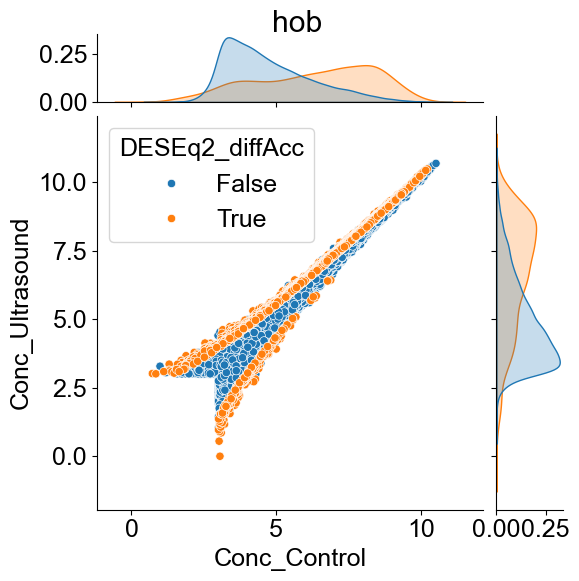

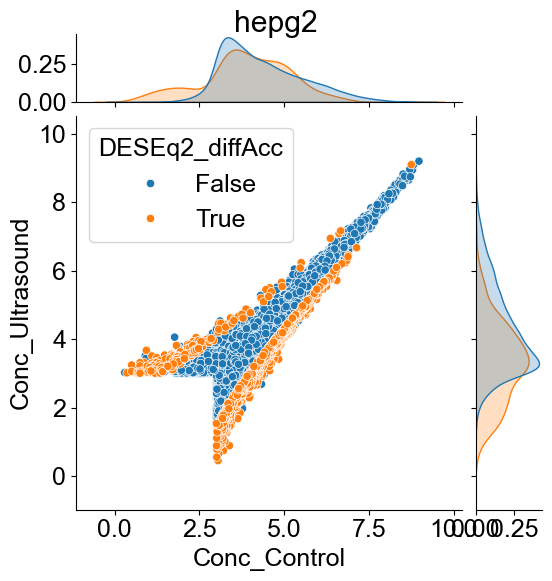

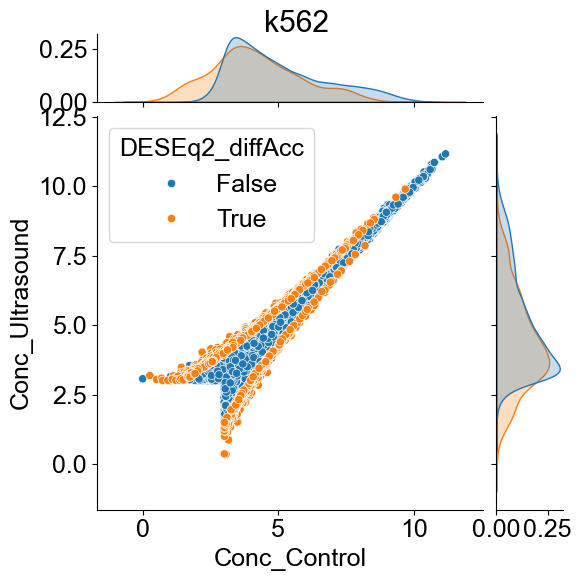

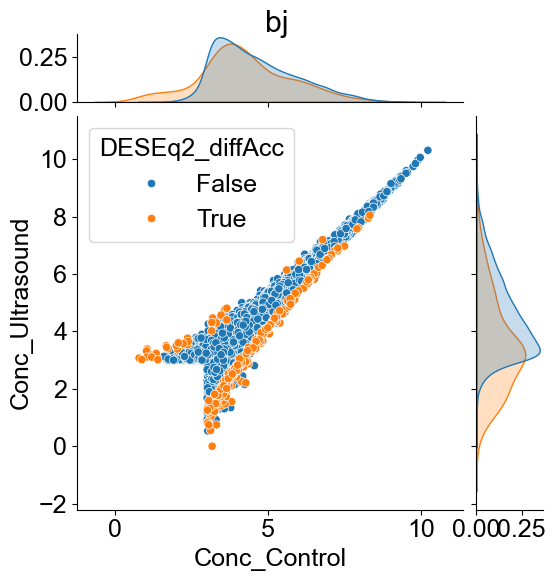

In [14]:
difs, dfs = {}, {}
for CL in CLS:
    NONDIFF = os.path.join(DATA_PATH, f"{CL}_deseq2-nondiff.csv")
    DIFF = os.path.join(DATA_PATH, f"{CL}_deseq2.csv")
    FULL = os.path.join(DATA_PATH, f"{CL}_deseq2-nondiff.trimmed.min_conc.{MIN_CONC}.full.csv")

    df = pd.read_csv(NONDIFF, usecols=cols).drop_duplicates()
    dif = pd.read_csv(DIFF, usecols=cols).drop_duplicates()

    print(CL)  # , dif.describe(), df.describe())
    df = addCoor(df)
    dif = addCoor(dif)
    
    df["cl"] = CL
    dif["cl"]=CL
    df.rename(columns={"seqnames":"#chr"}, inplace=True)

    # label sequence. 
    df = labelDf(df, "type", CL)
    dif = labelDf(dif, "type", CL + ".diffAcc")
    
    
    
    #out_beddif, beddf = makeBed(dif, DIFF, CL, "diff")
    #out_bednondif, beddf = makeBed(df, NONDIFF, CL, "non.diff")
    
    # subtraction to find out overlap between diff, nondiff tables. 
    
    #overlapDiffNondiff(out_beddif, out_bednondif, dif)

    df = minReadDepthFilter(df, MIN_CONC, "Conc_Control", "Conc_Ultrasound")
    dif = minReadDepthFilter(dif, MIN_CONC, "Conc_Control", "Conc_Ultrasound")
    
    # plot scatterplot of concentrations
    plotScatter(df, dif, CL)
    

    dfShapeSummary(df, dif)
    

    # compute peak midpoint
    df = computeMidpoint(df)
    
    # compute activity difference
    df["Conc_Ultrasound_dif"] = df["Conc_Control"] - df["Conc_Ultrasound"] 
    
    
    # trim peaks so that input size is comparable w/ MPRA
    trim_df, trim_bed = trimPeak(df, PEAK_SIZE, HG38, CL, "deseq2")
    
    # get fasta
    trim_fa = bed2Fasta(trim_bed, FA_HG38)
    
    # make fasta a dataframe
    fa_df = fastaDf(trim_fa)
    
    # merge trim_df w/ concn values, fasta sequences
    trim_df = addCoor(trim_df) # add coordinates for merging with fa
    trim_df.rename(columns = {"coor":"seq.id"}, inplace=True) # rename to merge w fa

    merged = pd.merge(trim_df, df[['type', "Conc_Ultrasound", "Conc_Control", "Conc_Ultrasound_dif"]]) # merge trim_df peaks w/ conc values on "type"
    merged = pd.merge(merged, fa_df) # merge df w/ sequences
    
    # write full data 
    merged.to_csv(FULL, sep='\t', index=False)
    
    # add to dictionary
    dfs[CL]= df
    difs[CL] = dif

In [ ]:
pd.concat(dfs.values())